### file import & dataset

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

In [1]:
import warnings # 경고 제거
warnings.filterwarnings('ignore')

In [4]:
train_img_dir = "../data/train"
train_df = pd.read_csv("../data/train.csv")

### data 분석

In [5]:
# ========== Blur Score (Laplacian variance) ==========
def calc_blur_score(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [6]:
# ========== Noise Score (FFT-based) ==========
def calc_noise_score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return np.var(magnitude_spectrum)

In [7]:
# ========== Motion Blur Score (Edge 방향성 std) ==========
def calc_motion_blur_score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None and len(lines) > 0:
        angles = [(theta * 180 / np.pi) for [[_, theta]] in lines]
        return np.std(angles)
    else:
        return 0

In [8]:
# ========== Skew Angle (Hough Transform) ==========
def calc_skew_angle(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None:
        angles = [(theta * 180 / np.pi) - 90 for [[_, theta]] in lines]
        return np.median(angles)
    else:
        return 0

In [9]:
# ========== Mask Ratio ==========
def calc_mask_ratio(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(binary == 255) / binary.size
    return white_ratio

In [10]:
# ========== 결과 저장 ==========
results = []

for idx, row in train_df.iterrows():
    file_name = row['ID']
    target = row['target']
    img_path = os.path.join(train_img_dir, file_name)
    
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    blur_score = calc_blur_score(img)
    noise_score = calc_noise_score(img)
    motion_blur_score = calc_motion_blur_score(img)
    skew_angle = calc_skew_angle(img)
    mask_ratio = calc_mask_ratio(img)

    results.append({
        'ID': file_name,
        'target': target,
        'blur_score': blur_score,
        'noise_score': noise_score,
        'motion_blur_score': motion_blur_score,
        'skew_angle': skew_angle,
        'mask_ratio': mask_ratio
    })

# DataFrame 생성
eda_df = pd.DataFrame(results)

# 저장
eda_df.to_csv("../data/train_eda_advanced.csv", index=False)

print("✅ EDA 분석 완료! 결과는 train_eda_advanced.csv 파일로 저장되었습니다.")

✅ EDA 분석 완료! 결과는 train_eda_advanced.csv 파일로 저장되었습니다.


### Test EDA 분포와 비교

In [11]:
train_eda_df = pd.read_csv("../data/train_eda_advanced.csv")

In [12]:
# Test 기준 분포 범위 (EDA advanced 기준 : 수정 가능)
test_blur_thresh = 500
test_noise_thresh = 800
test_skew_thresh = 30
test_mask_thresh = 0.1
test_motion_blur_thresh = 20

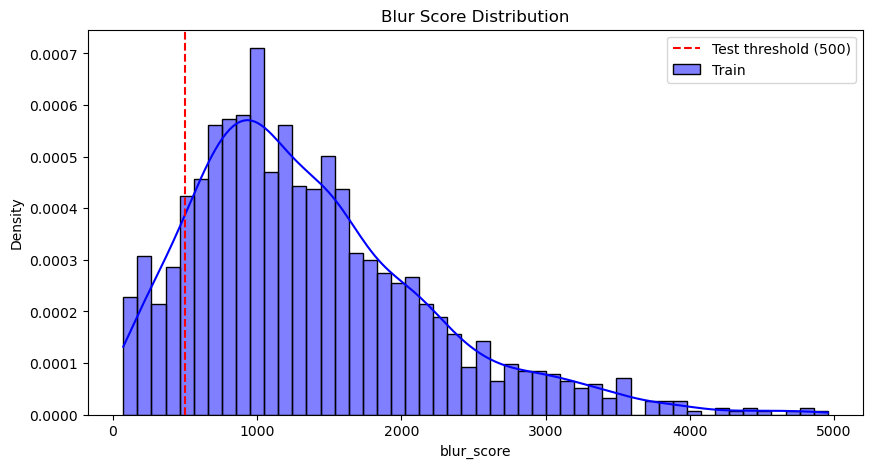

In [14]:
# Blur Score 분포 비교

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["blur_score"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_blur_thresh, color="red", linestyle="--", label=f"Test threshold ({test_blur_thresh})")
plt.title("Blur Score Distribution")
plt.legend()
plt.show()

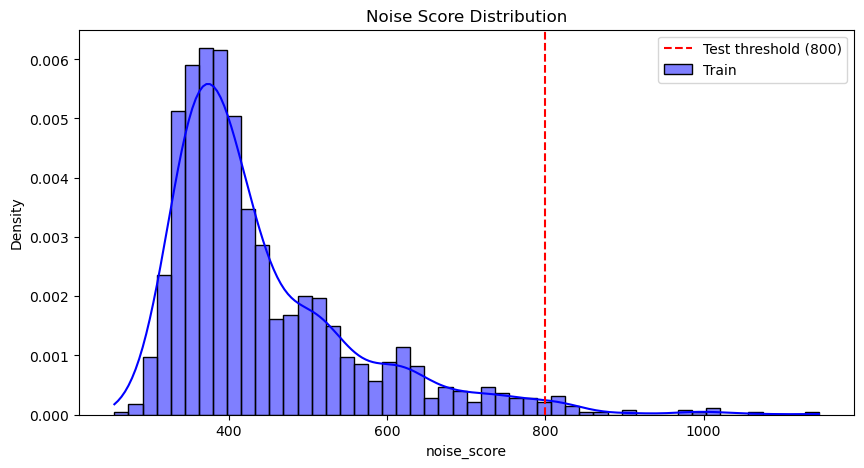

In [15]:
# Noise Score 분포 비교

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["noise_score"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_noise_thresh, color="red", linestyle="--", label=f"Test threshold ({test_noise_thresh})")
plt.title("Noise Score Distribution")
plt.legend()
plt.show()

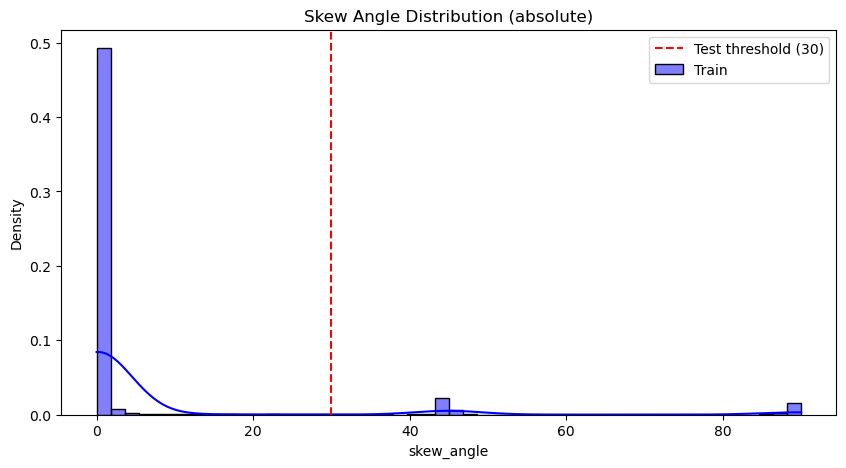

In [16]:
# Skew Angle 분포 비교

plt.figure(figsize=(10, 5))
sns.histplot(abs(train_eda_df["skew_angle"]), color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_skew_thresh, color="red", linestyle="--", label=f"Test threshold ({test_skew_thresh})")
plt.title("Skew Angle Distribution (absolute)")
plt.legend()
plt.show()

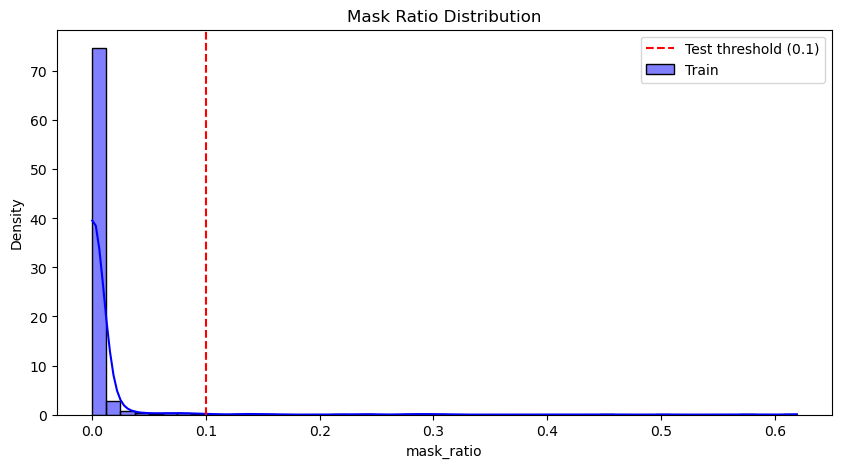

In [17]:
# Mask Ratio 분포 비교

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["mask_ratio"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_mask_thresh, color="red", linestyle="--", label=f"Test threshold ({test_mask_thresh})")
plt.title("Mask Ratio Distribution")
plt.legend()
plt.show()

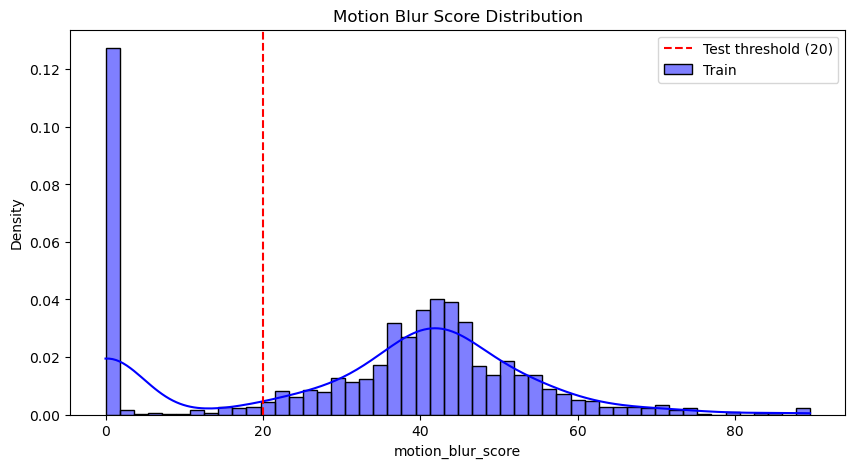

In [19]:
# Motion Blur Score 분포 비교

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["motion_blur_score"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_motion_blur_thresh, color="red", linestyle="--", label=f"Test threshold ({test_motion_blur_thresh})")
plt.title("Motion Blur Score Distribution")
plt.legend()
plt.show()

In [18]:
# 💡 각 항목별 augmentation 설계 힌트 출력

print("✅ 증강 설계 제안")

# Blur
blur_ratio = (train_eda_df["blur_score"] < test_blur_thresh).mean()
print(f"Blur 비율 (Train): {blur_ratio:.2%} → Test 비율에 맞게 blur augmentation 필요 여부 고려")

# Noise
noise_ratio = (train_eda_df["noise_score"] > test_noise_thresh).mean()
print(f"Noise-heavy 비율 (Train): {noise_ratio:.2%} → Noise injection 추가 필요 여부 고려")

# Skew
skew_ratio = (abs(train_eda_df["skew_angle"]) > test_skew_thresh).mean()
print(f"큰 Skew Angle 비율 (Train): {skew_ratio:.2%} → Random rotation augmentation 필요 여부 고려")

# Mask
mask_ratio = (train_eda_df["mask_ratio"] > test_mask_thresh).mean()
print(f"Mask-heavy 비율 (Train): {mask_ratio:.2%} → Cutout, Random erasing 등 마스킹 augmentation 필요 여부 고려")

# Motion Blur
motion_blur_ratio = (train_eda_df["motion_blur_score"] < test_motion_blur_thresh).mean()
print(f"강한 Motion blur 비율 (Train): {motion_blur_ratio:.2%} → Motion blur augmentation 필요 여부 고려")

✅ 증강 설계 제안
Blur 비율 (Train): 11.46% → Test 비율에 맞게 blur augmentation 필요 여부 고려
Noise-heavy 비율 (Train): 1.91% → Noise injection 추가 필요 여부 고려
큰 Skew Angle 비율 (Train): 8.85% → Random rotation augmentation 필요 여부 고려
Mask-heavy 비율 (Train): 1.46% → Cutout, Random erasing 등 마스킹 augmentation 필요 여부 고려
강한 Motion blur 비율 (Train): 25.03% → Motion blur augmentation 필요 여부 고려
